In [1]:
import numpy as np
import sklearn.metrics
import sklearn.svm
import sklearn.linear_model
import sklearn.ensemble
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')

In [2]:
df_train_verbose = pd.read_csv('train.csv', index_col=False)
df_test_verbose = pd.read_csv('test.csv', index_col=False)
df_train = df_train_verbose.drop(['Amount', 'Class'], axis=1)
df_test = df_test_verbose.drop(['Amount', 'Class'], axis=1)
df_train_verbose[:5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Amount,Class
0,1.031248,-0.072050,-0.670876,0.229800,-0.110964,-0.717370,0.062495,-0.159257,0.272605,0.227314,0.991693,1.072832,-0.203424,0.535359,-0.346886,0
1,0.634638,0.066966,0.248198,0.310266,-0.266923,-0.383850,-0.099650,0.017669,-0.029575,0.124333,0.988165,0.385953,-0.778380,0.657550,-0.350666,0
2,-0.377653,-0.335355,0.935346,-2.305539,-0.334195,0.210266,-0.291444,0.266795,-1.873973,0.696620,-0.049903,-1.357454,-0.997217,-0.314179,-0.201388,0
3,-0.150965,1.069422,-0.373497,2.864481,1.103171,1.053799,0.451532,0.543179,-2.217048,1.538206,-0.786411,-0.601413,-0.501937,1.100703,-0.279458,0
4,0.053348,0.777710,-1.284370,-0.330396,0.908994,-0.908333,0.974965,0.036462,-0.527542,-1.028895,-1.187415,-0.360524,-0.370287,-0.401160,-0.305920,0


In [3]:
print('0: %d\n1: %d' % tuple(df_train_verbose['Class'].value_counts()))
print('total: %d' % len(df_train_verbose))

0: 227453
1: 392
total: 227845


# Exercise 1.
## Removal of outliers

In [4]:
def mahalanobis_distance(X, mean, cov):
    pre = np.linalg.inv(cov)
    X_ = X - mean.reshape(1, -1)
    return np.sqrt(np.sum(X_.dot(pre) * X_, axis=1))

In [5]:
mean = df_train.mean().values
cov = df_train.cov().values

distances = mahalanobis_distance(df_train.values, mean, cov)
df_train_verbose['Outlier'] = pd.Series(distances > 50, index=df_train_verbose.index)
df_no_outlier_verbose = df_train_verbose[distances < 50]
df_no_outlier = df_train[distances < 50]

df_no_outlier_verbose[:5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Amount,Class,Outlier
0,1.031248,-0.072050,-0.670876,0.229800,-0.110964,-0.717370,0.062495,-0.159257,0.272605,0.227314,0.991693,1.072832,-0.203424,0.535359,-0.346886,0,False
1,0.634638,0.066966,0.248198,0.310266,-0.266923,-0.383850,-0.099650,0.017669,-0.029575,0.124333,0.988165,0.385953,-0.778380,0.657550,-0.350666,0,False
2,-0.377653,-0.335355,0.935346,-2.305539,-0.334195,0.210266,-0.291444,0.266795,-1.873973,0.696620,-0.049903,-1.357454,-0.997217,-0.314179,-0.201388,0,False
3,-0.150965,1.069422,-0.373497,2.864481,1.103171,1.053799,0.451532,0.543179,-2.217048,1.538206,-0.786411,-0.601413,-0.501937,1.100703,-0.279458,0,False
4,0.053348,0.777710,-1.284370,-0.330396,0.908994,-0.908333,0.974965,0.036462,-0.527542,-1.028895,-1.187415,-0.360524,-0.370287,-0.401160,-0.305920,0,False


In [6]:
print('0: %d\n1: %d' % tuple(df_no_outlier_verbose['Class'].value_counts()))
print('total: %d' % len(df_no_outlier.index))
print('remaining(%%): %f' % (len(df_no_outlier.index) / len(df_train.index)))

0: 227446
1: 391
total: 227837
remaining(%): 0.999965


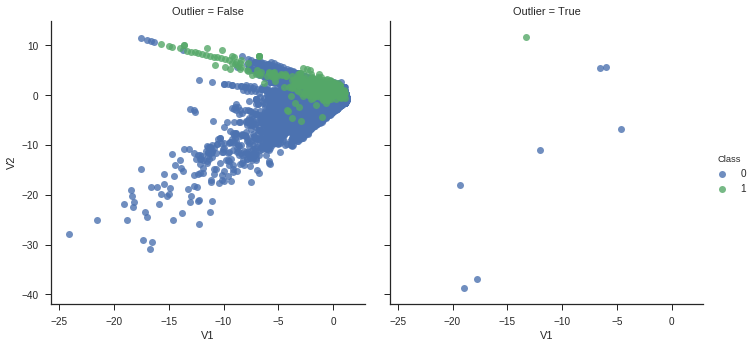

In [7]:
sns.lmplot('V1', 'V2', data=df_train_verbose, hue='Class', fit_reg=False, col='Outlier')

# Exercise 2.
## Classification by LR without downsampling

In [8]:
X_train = df_no_outlier.values
y_train = df_no_outlier_verbose['Class'].values
X_test = df_test.values
y_test = df_test_verbose['Class'].values

In [9]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
def print_result(X, y, predict, mode):
    np.set_printoptions(precision=2)
    print('Result for %s data:' % mode)
    print('confusion matrix:')
    prediction = predict(X)
    print(sklearn.metrics.confusion_matrix(y, prediction))
    fpr, tpr = sklearn.metrics.roc_curve(y, prediction)[:2]
    print('auc: %f' % sklearn.metrics.auc(fpr, tpr))

In [11]:
print_result(X_train, y_train, logistic.predict, 'train')
print_result(X_test, y_test, logistic.predict, 'test')

Result for train data:
confusion matrix:
[[227408     38]
 [   158    233]]
auc: 0.797870
Result for test data:
confusion matrix:
[[56849    13]
 [   38    62]]
auc: 0.809886


## Classification by LR with downsampling

In [12]:
df_positive_verbose = df_no_outlier_verbose[df_no_outlier_verbose['Class'] == 1]
df_negative_verbose = df_no_outlier_verbose[df_no_outlier_verbose['Class'] == 0]
df_negative_sampled_verbose = df_negative_verbose.sample(n=len(df_positive_verbose.index), random_state=0)
df_sampled_verbose = pd.concat([df_positive_verbose, df_negative_sampled_verbose])
X_sampled = df_sampled_verbose.drop(['Amount', 'Class', 'Outlier'], axis=1).values
y_sampled = df_sampled_verbose['Class'].values

print('%d records are resampled to %d records' % (len(df_negative_verbose.index), len(df_positive_verbose.index)))

227446 records are resampled to 391 records


In [13]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(X_sampled, y_sampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
print_result(X_train, y_train, logistic.predict, 'train')
print_result(X_test, y_test, logistic.predict, 'test')

Result for train data:
confusion matrix:
[[218769   8677]
 [    35    356]]
auc: 0.936168
Result for test data:
confusion matrix:
[[54677  2185]
 [    5    95]]
auc: 0.955787


# Exercise 3.
## Classification by LR with downsampling + bagging

In [15]:
# sklearn.ensemble.VotingClassifier は勝手に re-fit するため自作
class VotingClassifier(object):
    def __init__(self, estimators):
        self._estimators = estimators
    
    def predict(self, X):
        predictions = [estimator.predict(X) for estimator in self._estimators]
        prediction = np.sum(predictions, axis=0) > (len(predictions) / 2)
        return prediction.astype(int)

In [16]:
classifiers = []
for i in range(100):
    df_negative_sampled_verbose = df_negative_verbose.sample(n=len(df_positive_verbose.index), random_state=i)
    df_sampled_verbose = pd.concat([df_positive_verbose, df_negative_sampled_verbose])
    X = df_sampled_verbose.drop(['Amount', 'Class', 'Outlier'], axis=1).values
    y = df_sampled_verbose['Class'].values
    logistic = sklearn.linear_model.LogisticRegression()
    logistic.fit(X, y)
    classifiers += [logistic]

ensemble = VotingClassifier(classifiers)

In [17]:
print_result(X_train, y_train, ensemble.predict, 'train')
print_result(X_test, y_test, ensemble.predict, 'test')

Result for train data:
confusion matrix:
[[221150   6296]
 [    35    356]]
auc: 0.941402
Result for test data:
confusion matrix:
[[55255  1607]
 [    6    94]]
auc: 0.955869


## Classification by SVM with downsampling + bagging

In [18]:
classifiers = []
for i in range(10):
    df_negative_sampled_verbose = df_negative_verbose.sample(n=len(df_positive_verbose.index), random_state=i)
    df_sampled_verbose = pd.concat([df_positive_verbose, df_negative_sampled_verbose])
    X = df_sampled_verbose.drop(['Amount', 'Class', 'Outlier'], axis=1).values
    y = df_sampled_verbose['Class'].values
    svm = sklearn.svm.SVC()
    svm.fit(X, y)
    classifiers += [svm]

ensemble = VotingClassifier(classifiers)

In [19]:
print_result(X_train, y_train, ensemble.predict, 'train')
print_result(X_test, y_test, ensemble.predict, 'test')

Result for train data:
confusion matrix:
[[216409  11037]
 [    29    362]]
auc: 0.938653
Result for test data:
confusion matrix:
[[53982  2880]
 [    5    95]]
auc: 0.949676


# Exercise 4.
## Hyperparameter tuning using CV

In [20]:
def grid_search(train_features, train_labels):
    param_grid = [
        {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
        {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
    ]
    cv = sklearn.model_selection.GridSearchCV(sklearn.svm.SVC(), param_grid, n_jobs=-1)
    cv.fit(train_features, train_labels)
    return cv.best_estimator_

In [21]:
svm = sklearn.svm.SVC()
svm.fit(X_sampled, y_sampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
print_result(X_train, y_train, svm.predict, 'train')
print_result(X_test, y_test, svm.predict, 'test')

Result for train data:
confusion matrix:
[[214799  12647]
 [    26    365]]
auc: 0.938950
Result for test data:
confusion matrix:
[[53629  3233]
 [    5    95]]
auc: 0.946572


In [23]:
svm_cross_validated = grid_search(X_sampled, y_sampled)
svm_cross_validated

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
print_result(X_train, y_train, svm_cross_validated.predict, 'train')
print_result(X_test, y_test, svm_cross_validated.predict, 'test')

Result for train data:
confusion matrix:
[[222201   5245]
 [    34    357]]
auc: 0.944992
Result for test data:
confusion matrix:
[[55525  1337]
 [    8    92]]
auc: 0.948243
